In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
abs_path = "/content/drive/MyDrive/atml"
sys.path.append(abs_path+"/models")
sys.path.append(abs_path+"/train")
sys.path.append(abs_path+"/datasets")

In [16]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [17]:
from datasets import train_test_random_split, load_dsprites
from train import train_control_vae, test_control_vae
from loss import loss_control_vae
from control_vae import ControlVAEDSprites

In [18]:
dataset = load_dsprites(abs_path + "/datasets/dsprites.npz")

In [19]:
dataset = torch.from_numpy(dataset)

In [20]:
n_imgs = 50000
#indices = torch.randperm(dataset.size(0))[:n_imgs]
indices = torch.randperm(dataset.size(0))
dataset = dataset[indices]

In [21]:
data_train, data_test = train_test_random_split(dataset, 0.8)

In [22]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [23]:
beta_controller_args = {
    'C' : 0.5,
    'C_max' : 8,
    'C_step_val' : 0.15,
    'C_step_period' : 5000,
    'Kp' : 0.01,
    'Ki' : -0.001,
    'Kd' : 0.0
}

In [24]:
model = ControlVAEDSprites(beta_controller_args)
model.to(device)

ControlVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [25]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

In [26]:
train_loss, recon_loss, kl_div = train_control_vae(model, 50, train_loader, optimizer, 'bernoulli', device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: 164.89473944654068, recon loss: 105.34478110488918, kl div: 3.3205935931277293
Epoch 1 finished, loss: 149.37936353766256, recon loss: 111.76529765046305, kl div: 1.298815436506023
Epoch 2 finished, loss: 150.76507678214045, recon loss: 118.1155313923955, kl div: 1.0684462603595521
Epoch 3 finished, loss: 149.15173731247583, recon loss: 113.94426071726613, kl div: 1.2020339292098976
Epoch 4 finished, loss: 146.42241338143745, recon loss: 106.85457873758342, kl div: 1.4468229503707133
Epoch 5 finished, loss: 142.7772039655182, recon loss: 99.53387098097139, kl div: 1.7137357806916245
Epoch 6 finished, loss: 138.71708772662612, recon loss: 92.5063023865223, kl div: 1.9976675129987091
Epoch 7 finished, loss: 134.18531249794694, recon loss: 85.87207001861599, kl div: 2.288703172118403
Epoch 8 finished, loss: 129.39537358035645, recon loss: 79.72210028602018, kl div: 2.5790155227554754
Epoch 9 finished, loss: 124.59856270915932, recon loss: 74.04120372566912, kl div:

In [ ]:
test_control_vae(model, test_loader, 'bernoulli', device = device)

In [27]:
torch.save(model, '/content/drive/MyDrive/atml/controlvae_epoch40_lr1e2_Cmax8.dat')
np.save('/content/drive/MyDrive/atml/controlvae_epoch50_lr1e2_Cmax8_train_loss.npy', train_loss)
np.save('/content/drive/MyDrive/atml/controlvae_epoch50_lr1e2_Cmax8_recon_loss.npy', recon_loss)
np.save('/content/drive/MyDrive/atml/controlvae_epoch50_lr1e2_Cmax8_kl_divs.npy', kl_div)

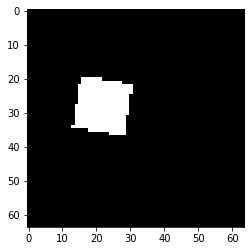

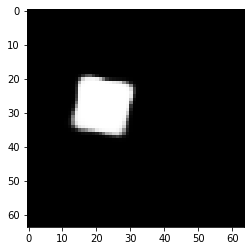

In [ ]:
model = torch.load('/content/drive/MyDrive/atml/controlvae_epoch500_lr1e2_Cmax12.dat')
index = 100
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

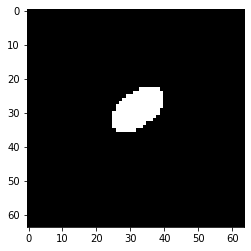

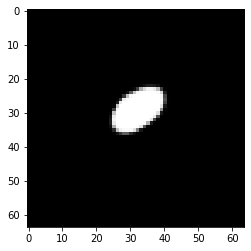

In [ ]:
index = 198964
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()